In [13]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [33]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }


absolute_path = "c:/thesis/data/quant"
metadata_path = "c:/thesis/METADATA_200123.xlsx"


x_train, filenames, n_genes = data_handler.generate_dataset(path = absolute_path,
                                                            metadata_path = metadata_path,
                                                            feature_selection_threshold = 25, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   #retain_phases=None, 
                                                   return_id = True,
                                                   sgdc_params = sgdc_params,
                                                   #subsample = 100,
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced",
                                                   as_time_series = True,
                                                   normalization = True,
                                                   transpose=True)


c://////thesis/data/quant
Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...


In [69]:
importlib.reload(LSTM) # to allow modification of the script without restarting the whole session

latent_dim = 64
sequence_length = 5

t_shape = (sequence_length, n_genes)

# SINCE WE USE TRANSPOSE :
t_shape = (n_genes, sequence_length)


autoencoder = LSTM.generate_model(t_shape, latent_dim, True)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [70]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=25, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=50)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [71]:
#%tensorboard --logdir ../workfiles/logs/fit

In [72]:
autoencoder.build( (None, n_genes, sequence_length))

In [73]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_19 (Bidirecti  (None, 1024)             2121728   
 onal)                                                           
                                                                 
Total params: 2,121,728
Trainable params: 2,121,728
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector_9 (RepeatVect  (None, 1014, 1024)       0         
 or)                                                             
                                                                 
 bidirectional_20 (Bidirecti  (None, 1014, 1024)       6295552   
 onal)                                                           
                    

In [74]:
hist = autoencoder.fit(x_train, epochs=100, callbacks=cb)

Epoch 1/100
3/5 [=================>............] - ETA: 47s - loss: 0.0034 

In [48]:
autoencoder.load_weights(checkpoint_filepath)


[0.00568774901330471, 0.0014573929365724325, 0.001687357435002923, 0.0017046461580321193, 0.0015980651369318366, 0.001460451865568757, 0.0013605734566226602, 0.0012822342105209827, 0.0012112698750570416, 0.0011454734485596418, 0.0011033989721909165, 0.0010700958082452416, 0.00102293211966753, 0.0009639870258979499, 0.0009402964496985078, 0.0009304314153268933, 0.0009219414787366986, 0.0009113303385674953, 0.0009179958724416792, 0.0009294873452745378, 0.0009210189455188811, 0.0009079856099560857, 0.0008962196297943592, 0.0008813871536403894, 0.0008779947529546916, 0.0008773929439485073, 0.0008775991736911237, 0.0008779519121162593, 0.0008786501712165773, 0.0008789452258497477, 0.0008785774698480964, 0.0008782194927334785, 0.000878184859175235, 0.0008784206584095955, 0.0008795109461061656, 0.0008807752165012062, 0.0008845613338053226, 0.0008889022283256054, 0.0009027197957038879, 0.0009012093069031835, 0.0008944729343056679, 0.0008991442155092955, 0.0008861373062245548, 0.000886029913090

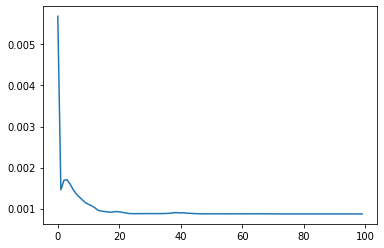

In [49]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




### some diagnosis

In [50]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [51]:
e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
tensor_reshaped = z.reshape(1, -1)
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [11]:
autoencoder.encoder.save('../workfiles/LSTM')


INFO:tensorflow:Assets written to: ../workfiles/LSTM/assets


In [12]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

5/5 [==============================] - 1s 13ms/step


In [13]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [15]:
df.to_csv("../workfiles/processed_data_lstm.csv", index=False)
